# Camels example

Use test cosmological simulation data (from the [CAMELS simulations](https://www.camel-simulations.org/)) to generate spectra and calculate photometry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.filters import UVJ

In [2]:
grid_dir = '../../../tests/test_grid'
grid_name = 'test_grid'
grid = Grid(grid_name, grid_dir=grid_dir)

We then need to load our galaxy data. There are custom data loading script for different simulation codes in `synthesizer.load_data`. For CAMELS-Simba there is the `load_CAMELS_SIMBA` method

If your simulation does not have its own front end, please use the templates in `synthesizer/load_data.py` to create your own.

In [3]:
gals = load_CAMELS_IllustrisTNG('../../../tests/data/', 
                                snap_name='camels_snap.hdf5', 
                                fof_name='camels_subhalo.hdf5')

len(gals)

10

this creates `gals`, which is a list containing a `synthesizer.Galaxy` object for each structure in the subfind file. These `Galaxy` objects contain lots of useful methods for acting on galaxies, one of which is to generate the intrinsic spectrum.

In [4]:
g = gals[0]
spec = g.get_spectra_incident(grid)

Here we grab a single galaxy, and call `get_spectra_incident` providing our grid object as the first argument. This returns the spectra as an `Sed` object.

To access the luminosity and wavelength for `_spec` we can now do

In [5]:
spec.lam[:10], spec.lnu[:10]

(unyt_array([0.00012454, 0.00012492, 0.00012529, 0.00012567, 0.00012605,
        0.00012642, 0.0001268 , 0.00012719, 0.00012757, 0.00012795], 'Å'),
 unyt_array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 'erg/(Hz*s)'))

Notice that these are unyt arrays with associated units. To plot the spectra manually:

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

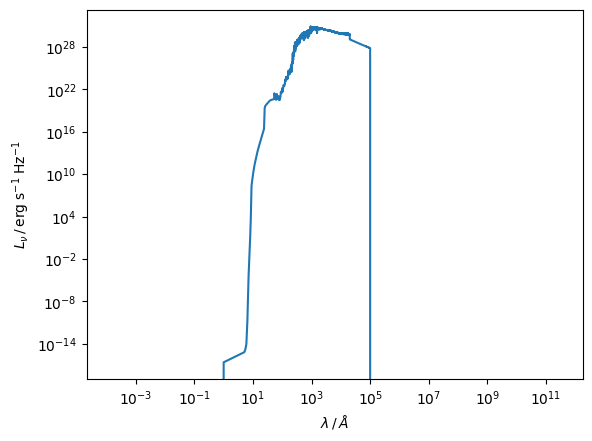

In [6]:
plt.loglog(spec.lam, spec.lnu)
plt.xlabel('$\lambda \,/\, \\AA$')
plt.ylabel('$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$')

We can also use the `plot_spectra` method in the galaxy object to plot all of the spectra associated with a galaxy at once

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


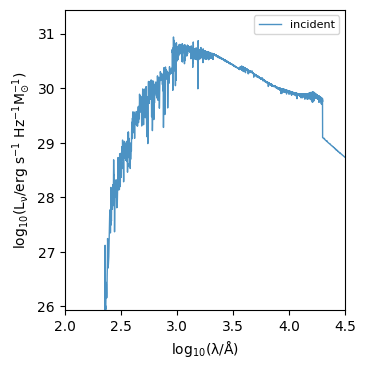

In [7]:
g.plot_spectra()
plt.show()

Why might you want to create an `Sed` object? This class contains a lot of useful functionality for working with SED's. For example, we can calculate the broadband luminosities.

First, get rest frame 'flux'

In [8]:
spec.get_fnu0()

unyt_array([0., 0., 0., ..., 0., 0., 0.], 'nJy')

Define a filter collection object (UVJ default)

In [9]:
fc = UVJ(new_lam=grid.lam)
_UVJ = spec.get_broadband_fluxes(fc)
print(_UVJ)

{'U': unyt_quantity(1.99387773e+22, 'nJy'), 'V': unyt_quantity(1.31337811e+22, 'nJy'), 'J': unyt_quantity(6.52567901e+21, 'nJy')}


## Young and old stellar populations

We restrict the age of star particles used for calculating the spectra. The age is specific by the `young` and `old` parameters; these defaault to `None`, but if set to a avlue of age (in units of years) they will filter the star particles above or below this value. If both `young` and `old` are set, the code will raise an error.

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

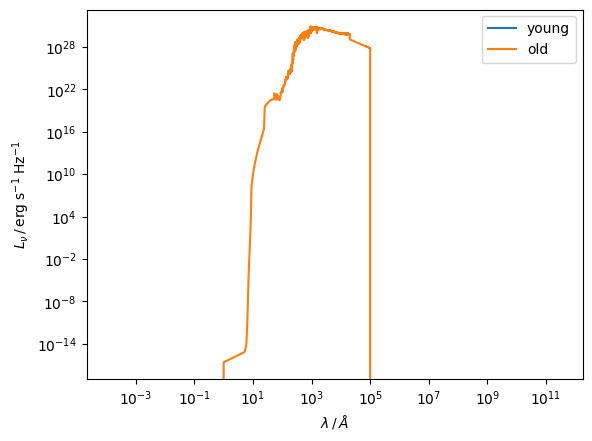

In [10]:
young_spec = g.get_spectra_incident(grid, young=1e7)
old_spec = g.get_spectra_incident(grid, old=1e7)

plt.loglog(young_spec.lam, young_spec.lnu, label='young')
plt.loglog(old_spec.lam, old_spec.lnu, label='old')
plt.legend()
plt.xlabel('$\lambda \,/\, \\AA$')
plt.ylabel('$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$')

## Nebular emission

If our grid file has been post-processed with CLOUDY we can produce the nebular emission for our camels galaxies. `get_spectra_nebular` produces the pure nebular emission

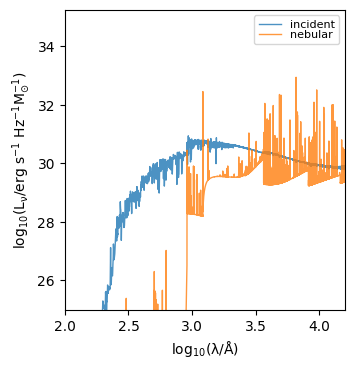

In [11]:
spec = g.get_spectra_nebular(grid)
fig, ax = g.plot_spectra()
ax.set_ylim(25,)
ax.set_xlim(2, 4.2)
plt.show()

`get_spectra_reprocessed` calculates the gas reprocessed spectra, which we refer to as the *reprocessed* spectra, assuming some escape fraction `fesc`. The combination of the  *reprocessed* and  *escaped* spectra is the *intrinsic* spectra. 

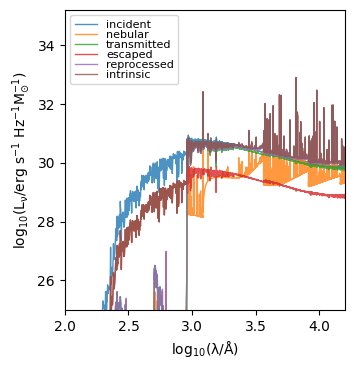

In [12]:
spec = g.get_spectra_reprocessed(grid, fesc=0.1)
fig, ax = g.plot_spectra()
ax.set_ylim(25,)
ax.set_xlim(2, 4.2)
plt.show()

## Dust attenuation

We can apply a range of different dust models to our intrinsic spectra. `get_spectra_screen` applies a simple dust screen to all stellar particles, assuming a V band optical depth $\tau_V$

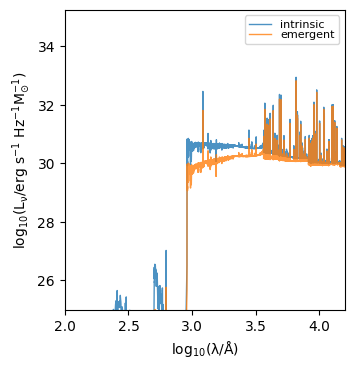

In [13]:
spec = g.get_spectra_screen(grid, tau_v=0.33)
fig, ax = g.plot_spectra(spectra_to_plot=['intrinsic', 'emergent'])
ax.set_ylim(25,)
ax.set_xlim(2, 4.2)
plt.show()

`get_spectra_CharlotFall` applies the [Charlot & Fall+00](https://ui.adsabs.harvard.edu/abs/2000ApJ...539..718C/abstract) two component dust screen model, with V band attenuation for young and old populations defined by the $\tau_V^{BC}$ and $\tau_V^{ISM}$

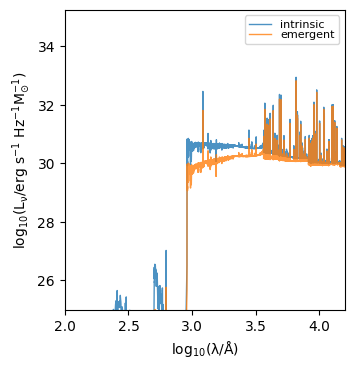

In [14]:
spec = g.get_spectra_CharlotFall(grid, tau_v_ISM=0.33, tau_v_BC=0.67)
fig, ax = g.plot_spectra(spectra_to_plot=['intrinsic', 'emergent'])
ax.set_ylim(25,)
ax.set_xlim(2, 4.2)
plt.show()

### Multiple galaxies 
If we want to create spectra for multiple galaxies we can use a list comprehension. Here we grab the luminosity `lnu` of each galaxy into a list, and combine into a single sed object afterwards using the grid wavelength.

In [15]:
specs = np.vstack([g.get_spectra_incident(grid).lnu for g in gals])
specs = Sed(lam=grid.lam, lnu=specs)

Importantly here, we don't create an SED object for each galaxy spectra. We instead create the 2D array of spectra, and then create an `Sed` object for the whole collection

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

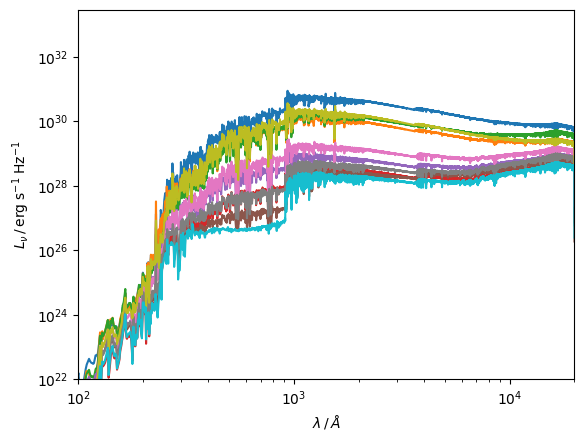

In [16]:
fig, ax = plt.subplots(1, 1)
ax.loglog(grid.lam, specs.lnu.T)
ax.set_ylim(1e22,)
ax.set_xlim(1e2, 2e4)
ax.set_xlabel('$\lambda \,/\, \\AA$')
ax.set_ylabel('$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$')

### Calculate broadband luminosities

We can then use the `Sed` methods on the whole collection. This is much faster than calling the method for each spectra individually, since we can take advantage of vectorisation. For example, we can calculate UVJ colours of all the selected galaxies in just a couple of lines.

First get rest frame 'flux'

In [17]:
spec.get_fnu0()

unyt_array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.22046961e+20, 2.21883385e+20, 2.21730892e+20], 'nJy')

Define a filter collection object (UVJ default)

In [18]:
fc = UVJ(new_lam=grid.lam)

_UVJ = spec.get_broadband_fluxes(fc)
print(_UVJ)

{'U': unyt_quantity(1.83937933e+22, 'nJy'), 'V': unyt_quantity(1.10428718e+22, 'nJy'), 'J': unyt_quantity(1.12890551e+22, 'nJy')}


Do for multiple, plot UVJ diagram, coloured by $M_{\star}$

In [19]:
mstar = np.log10(np.array([np.sum(g.stars.initial_masses)
                           for g in gals]) * 1e10)

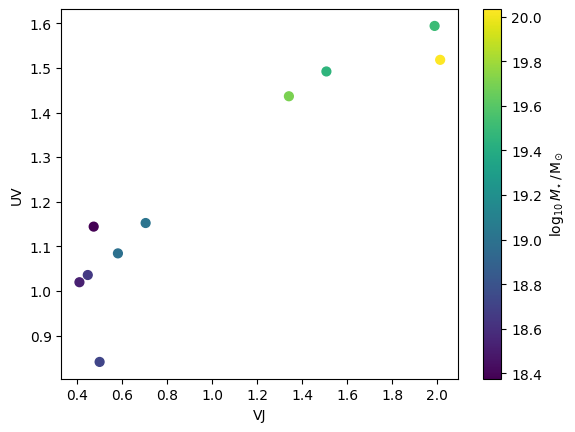

In [20]:
specs.get_fnu0()
_UVJ = specs.get_broadband_fluxes(fc)

UV = _UVJ['U'] / _UVJ['V']
VJ = _UVJ['V'] / _UVJ['J']

plt.scatter(VJ, UV, c=mstar, s=40)
plt.xlabel('VJ')
plt.ylabel('UV')
plt.colorbar(label='$\mathrm{log_{10}} \, M_{\star} \,/\, \mathrm{M_{\odot}}$')